In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
module_path = os.path.abspath(
    os.path.join(
        "/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control"
    )
)
if module_path not in sys.path:
    sys.path.append(module_path)

from spillover_noise_q_env_config import (
    q_env_config as gate_q_env_config,
    circuit_context,
)
from quantumenvironment import QuantumEnvironmentV2
from context_aware_quantum_environment import ContextAwareQuantumEnvironmentV2
from hyperparameter_optimization import HyperparameterOptimizer
from gymnasium.wrappers import RescaleAction, ClipAction

import logging

logging.basicConfig(
    level=logging.WARNING,
    format="%(asctime)s INFO %(message)s",  # hardcoded INFO level
    datefmt="%Y-%m-%d %H:%M:%S",
    stream=sys.stdout,
)

/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-06-05 15:46:12,930 - qm - INFO     - Starting session: 9b2dc90f-abc5-4df4-a188-c55899e97868

 NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'unitary']
  Instructions with noise: ['custom_kron(rx,ident)_gate']
  Qubits with noise: [0, 1]
  Specific qubit errors: [('custom_kron(rx,ident)_gate', (0, 1))] 

Circuit context
     ┌─────────────────────────────┐     
q_0: ┤0                            ├──■──
     │  custom_kron(rx,ident)_gate │┌─┴─┐
q_1: ┤1                            ├┤ X ├
     └─────────────────────────────┘└───┘


/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [2]:
gate_q_env_config.backend_config.instruction_durations_dict

In [3]:
q_env = ContextAwareQuantumEnvironmentV2(gate_q_env_config, circuit_context)
q_env = ClipAction(q_env)
q_env = RescaleAction(q_env, -1.0, 1.0)

q_env.unwrapped.backend

/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/qiskit_ibm_runtime/session.py:156: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>)

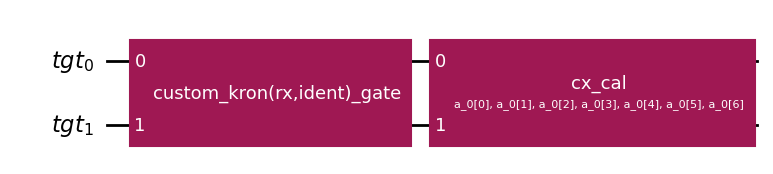

In [4]:
q_env.unwrapped.circuits[0].draw("mpl")

In [7]:
from ppoV2 import CustomPPOV2

In [8]:
from helper_functions import load_from_yaml_file

agent_config = load_from_yaml_file(
    "/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/template_configurations/agent_config.yaml"
)

ppo_agent = CustomPPOV2(agent_config, q_env)

training_config = {
    "training_mode": "Normal",
    "training_details": {
        "total_updates": 2_500,
        "target_fidelities": [0.99, 0.999, 0.9999],
        "lookback_window": 10,
        "anneal_learning_rate": True,  # TODO: Anneal it down to predefined lowest value, i.e., 5e-5
        "std_actions_eps": 1e-2,
    },
}

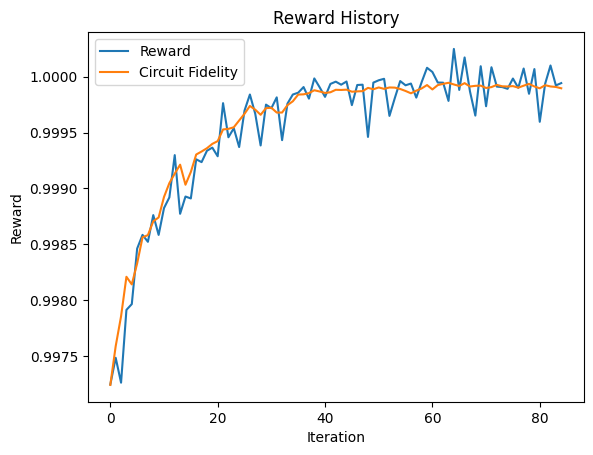

  3%|▎         | 85/2500 [11:22<5:34:57,  8.32s/it]

Fidelity stored 0.9999128390647981
Hardware runtime taken: 5350.411468799999
Sending Estimator job...


  3%|▎         | 85/2500 [11:31<5:27:36,  8.14s/it]


KeyboardInterrupt: 

In [9]:
training_results = ppo_agent.train(
    training_config=training_config,
    plot_real_time=True,
    print_debug=True,
    num_prints=1,
)